<a href="https://colab.research.google.com/github/mukeshrock7897/TensorFlow_Notes/blob/main/Advanced_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning**
* Transfer learning involves using a pre-trained model on a new task, which saves training time and leverages learned features from large datasets.

**Example:** Fine-tuning a pre-trained model on a new dataset



In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess the dataset
train_datagen = ImageDataGenerator(rescale=0.5)

# **Update with the correct path to your training data**
train_generator = train_datagen.flow_from_directory(
    '/content/train_data',  # Replace with the actual path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Train the model
model.fit(train_generator, epochs=10)

# Plot accuracy and loss during training
history = model.fit(train_generator, epochs=10)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Generative Adversarial Networks (GANs)**
* GANs consist of two networks, a generator and a discriminator, that compete against each other. The generator creates data, while the discriminator evaluates it. real or fake

**Example:** Simple GAN for generating MNIST digits



1/1 [==============================] - 0s 120ms/step
0 [D loss: 1.1080616116523743] [G loss: 0.8168544769287109]
1/1 [==============================] - 0s 107ms/step


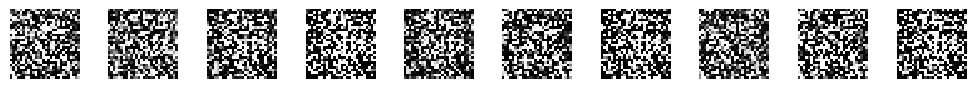

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt


# Define the generator
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

# Define the discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Define the combined GAN model
z = tf.keras.Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = tf.keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer='adam')

# Training the GAN
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train / 127.5 - 1.0
X_train = np.expand_dims(X_train, axis=3)
batch_size = 64
epochs = 100
half_batch = batch_size // 2

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)
    g_loss = combined.train_on_batch(noise, valid_y)

    if epoch % 1000 == 0:
        print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")


def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.show()

plot_generated_images(epochs, generator)


# **Autoencoders and Variational Autoencoders (VAEs)**
* Autoencoders compress data into a latent space and reconstruct it. VAEs add a probabilistic approach, ensuring a continuous latent space.

**Example:** Basic autoencoder for MNIST

Epoch 1/50
235/235 [==============================] - 3s 6ms/step - loss: 0.2437 - val_loss: 0.1669
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1499 - val_loss: 0.1360
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1313 - val_loss: 0.1253
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1232 - val_loss: 0.1193
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1173 - val_loss: 0.1132
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1123 - val_loss: 0.1092
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1088 - val_loss: 0.1061
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1065 - val_loss: 0.1041
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1047 - val_loss: 0.1025
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1032 - val_loss: 0.1009

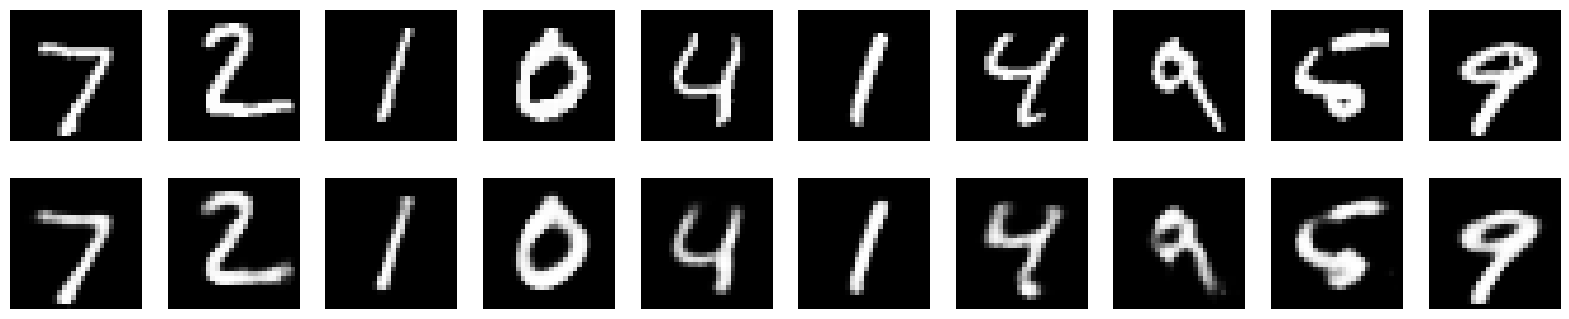

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the encoder
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

# Define the decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# Combine encoder and decoder into an autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Create the encoder model
encoder = Model(input_img, encoded) # Create the encoder model

# Load and preprocess the dataset
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

encoded_imgs = encoder.predict(X_test) # Now you can use the encoder model
decoded_imgs = autoencoder.predict(X_test)

n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')
plt.show()

**Variational Autoencoder Example:**



In [16]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define the encoder
input_img = Input(shape=(784,))
h = Dense(128, activation='relu')(input_img)
z_mean = Dense(2)(h)
z_log_var = Dense(2)(h)

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

# Define the decoder
decoder_h = Dense(128, activation='relu')
decoder_mean = Dense(784, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Define the VAE model
vae = Model(input_img, x_decoded_mean)

# Define the loss
def vae_loss(x, x_decoded_mean):
    xent_loss = tf.keras.backend.binary_crossentropy(x, x_decoded_mean) # Use tf.keras.backend.binary_crossentropy
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss) # Calculate mean of the sum of losses

vae.compile(optimizer='adam', loss=vae_loss)

# Train the VAE
# vae.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))


# **Attention Mechanism**
* Attention mechanisms allow models to focus on relevant parts of the input sequence, crucial in tasks like machine translation.

**Example:** Attention in Seq2Seq model

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention

# Define the encoder
encoder_inputs = Input(shape=(None, 128))
encoder_lstm = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# Define the decoder with attention
decoder_inputs = Input(shape=(None, 128))
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# Apply attention
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention])

# Define the output layer
decoder_dense = Dense(128, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# model.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=100)


# **Transformer**
* Transformers are a type of model architecture that relies entirely on self-attention mechanisms and is widely used in NLP tasks.

**Example:** Transformer for text classification

Epoch 1/10
4/4 [==============================] - 6s 203ms/step - loss: 3.2088 - accuracy: 0.0700 - val_loss: 3.3486 - val_accuracy: 0.0500
Epoch 2/10
4/4 [==============================] - 0s 46ms/step - loss: 2.0984 - accuracy: 0.3800 - val_loss: 3.2762 - val_accuracy: 0.1000
Epoch 3/10
4/4 [==============================] - 0s 16ms/step - loss: 1.3016 - accuracy: 0.8800 - val_loss: 3.3743 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7105 - accuracy: 1.0000 - val_loss: 3.4198 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 23ms/step - loss: 0.3351 - accuracy: 1.0000 - val_loss: 3.3805 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 16ms/step - loss: 0.1404 - accuracy: 1.0000 - val_loss: 3.3309 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 49ms/step - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.3001 - val_accuracy: 0.0500
Epoch 8/10

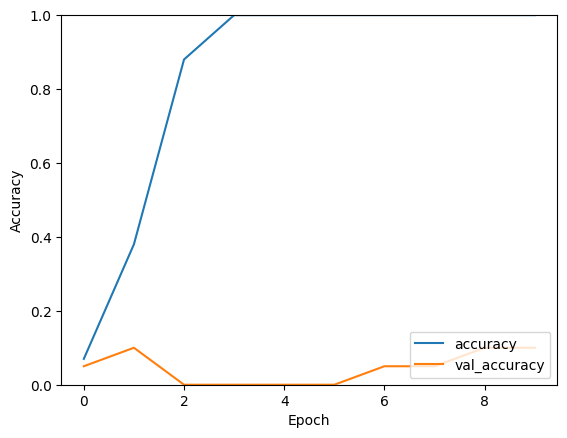

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Define the transformer block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    attn_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output + inputs)
    ffn_output = Dense(ff_dim, activation='relu')(attn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attn_output)
    return ffn_output

# Define the transformer model
inputs = Input(shape=(None,))
x = Embedding(input_dim=20000, output_dim=128)(inputs)
x = transformer_block(x, head_size=128, num_heads=4, ff_dim=128, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(20, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create some dummy data for demonstration purposes
import numpy as np
x_train = np.random.randint(20000, size=(100, 10))  # Replace with your actual training data
y_train = np.random.randint(20, size=(100,))  # Replace with your actual training labels
x_val = np.random.randint(20000, size=(20, 10))    # Replace with your actual validation data
y_val = np.random.randint(20, size=(20,))      # Replace with your actual validation labels

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

import matplotlib.pyplot as plt

# Assuming 'history' is obtained from model.fit()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()